<a href="https://colab.research.google.com/github/enfuego27826/srip-selection-task/blob/main/srip_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install supervision

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.6 MB/s eta 0:00:00


In [35]:
import os
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt
import supervision as sv
from collections import Counter
from shapely.geometry import box
from sklearn.metrics import precision_recall_curve,auc
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from collections import Counter
import glob
import cv2
from supervision.metrics import MeanAveragePrecision
from supervision.metrics.detection import ConfusionMatrix

path = "/content/drive/MyDrive/srip_task"
output_dir = "/content/drive/MyDrive/srip_task/split_data"

label_files = os.listdir(os.path.join(path,"labels/labels_native"))
print(os.path.exists(path))

True


In [2]:
!pip install ultralytics
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
label_dir = os.path.join(path,"labels/labels_native")
img_dir = os.path.join(path,"image_chips_native")

print(os.path.exists(label_dir))
label_per_img = []
total_instances = 0


for files in os.listdir(label_dir):
    file_path = os.path.join(label_dir,files)
    with open(file_path,"r") as fs:
        lines = fs.readlines()
        label_per_img.append(len(lines))
        total_instances += len(lines)

print(f"Total instances of solar panels: {total_instances}")

label_counts = Counter(label_per_img)
print(f"Label counts per image: {label_counts}")

True
Total instances of solar panels: 29625
Label counts per image: Counter({3: 221, 4: 218, 5: 217, 6: 189, 8: 184, 7: 170, 9: 169, 2: 167, 10: 121, 11: 97, 12: 84, 1: 81, 13: 69, 14: 49, 15: 46, 16: 41, 17: 36, 19: 29, 18: 25, 30: 20, 34: 19, 37: 17, 52: 16, 29: 15, 20: 14, 38: 13, 33: 13, 42: 12, 43: 11, 35: 10, 41: 10, 51: 9, 40: 9, 47: 9, 31: 8, 32: 7, 62: 6, 50: 6, 54: 6, 36: 6, 39: 6, 27: 5, 74: 5, 28: 5, 46: 5, 49: 5, 66: 4, 23: 4, 25: 4, 44: 4, 21: 4, 53: 4, 48: 3, 63: 3, 26: 3, 58: 3, 65: 3, 59: 2, 60: 2, 45: 2, 24: 2, 76: 2, 77: 2, 56: 1, 78: 1, 72: 1, 61: 1, 75: 1, 22: 1, 73: 1, 67: 1, 64: 1, 71: 1, 55: 1})


In [6]:
pixel_to_meter = 0.31
img_size = 416

areas = []

for files in os.listdir(label_dir):
    file_path = os.path.join(label_dir,files)
    with open(file_path,"r") as fs:
        for line in fs:
            parts = line.strip().split()
            _,_,_,width,height = map(float,parts)

            real_width = width*img_size*pixel_to_meter
            real_height = height*img_size*pixel_to_meter
            area = real_width*real_height

            areas.append(area)

mean_area = np.mean(areas)
std_area = np.std(areas)
print(f"Mean Area: {mean_area:.2f} sq. m")
print(f"Standard Deviation: {std_area:.2f} sq. m")

Mean Area: 191.52 sq. m
Standard Deviation: 630.70 sq. m


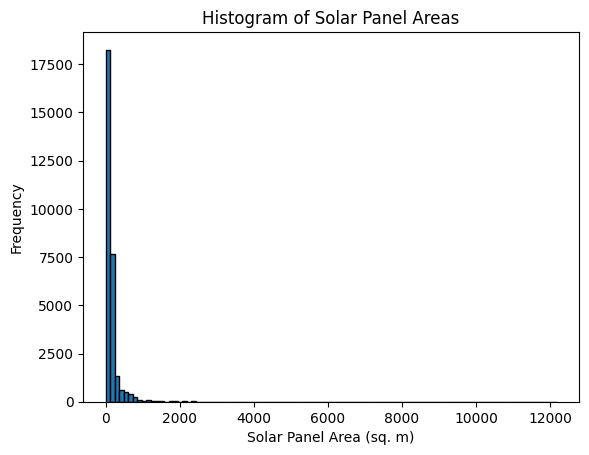

In [7]:
plt.hist(areas,bins=100,edgecolor='black')
plt.xlabel("Solar Panel Area (sq. m)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.show()

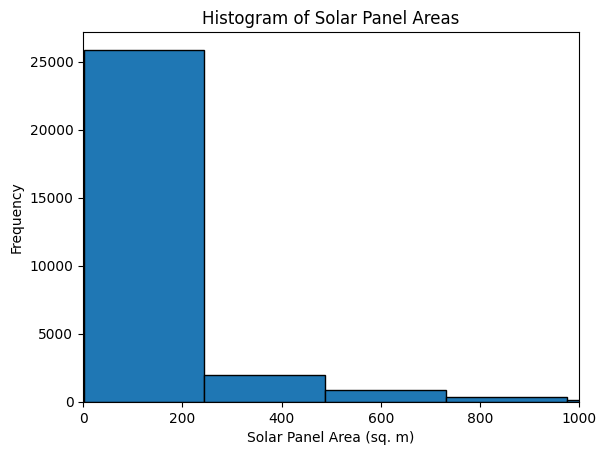

In [ ]:
plt.hist(areas,bins=50,edgecolor='black')
plt.xlim(0,1000)
plt.xlabel("Solar Panel Area (sq. m)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.show()

It can be seen that most of the solar panels are along the smaller side of the spectrum, and around the mean value, so there are a lot of outliers due to the high standard deviation.

**Section 2**

In [15]:
def bbox(bbox1,img_size=416):
    if(len(bbox1) > 4):
      bbox1 = bbox1[1:]

    x_center, y_center, width, height = bbox1
    x_min = (x_center - width/2)*img_size
    y_min = (y_center - height/2)*img_size
    x_max = (x_center + width/2)*img_size
    y_max = (y_center + height/2)*img_size

    return x_min, y_min, x_max, y_max

def compute_iou(bbox1,bbox2,img_size=416):
    x1_min,y1_min,x1_max,y1_max = bbox(bbox1,img_size)
    x2_min,y2_min,x2_max,y2_max = bbox(bbox2,img_size)

    box1 = box(x1_min,y1_min,x1_max,y1_max)
    box2 = box(x2_min,y2_min,x2_max,y2_max)

    intrsct = box1.intersection(box2).area
    union = box1.area + box2.area - intrsct

    return intrsct / union if union != 0 else 0.0

In [ ]:
bbox1 = (0.5,0.5,0.2,0.2)
bbox2 = (0.52,0.52,0.2,0.2)

iou_shapely = compute_iou(bbox1,bbox2)

print(f"IoU (Shapely): {iou_shapely:.4f}")

IoU (Shapely): 0.6807


In [27]:
def voc_11_pt_interpolation(precisions,recalls):
  recall_levels = np.linspace(0,1,11)
  ap = 0.0

  for r in recall_levels:
    prec_at_r = np.max(precisions[recalls >= r]) if np.any(recalls >= r) else 0
    ap += prec_at_r/11

  return ap

def coco_101_pt_interpolation(precisions,recalls):
    recall_levels = np.linspace(0,1,101)
    ap = 0.0

    for r in recall_levels:
        prec_at_r = np.max(precisions[recalls >= r]) if np.any(recalls >= r) else 0
        ap += prec_at_r / 101

    return ap

In [28]:
def generate_random_boxes(num_boxes=10,img_size=100,box_size=20):
    boxes = []

    for _ in range(num_boxes):
        x_center = random.uniform(box_size/2,img_size - box_size/2)/img_size
        y_center = random.uniform(box_size/2,img_size - box_size/2)/img_size

        width = box_size / img_size
        height = box_size / img_size

        boxes.append((x_center,y_center,width,height))

    return boxes

def generate_confidence_scores(num_boxes):
    return np.random.uniform(0.1, 1.0, num_boxes).tolist()

num_img = 10
ground_truth_boxes = [generate_random_boxes() for _ in range(num_img)]
predicted_boxes = [generate_random_boxes() for _ in range(num_img)]
predicted_confidences = [generate_confidence_scores(len(pred)) for pred in predicted_boxes]

In [29]:
def compute_ap50(gt_boxes, pred_boxes, conf_scores, method="pr_auc", iou_threshold=0.5):

    if len(pred_boxes) == 0:
        return 0.0

    sorted_indices = np.argsort(-np.array(conf_scores))
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    conf_scores = [conf_scores[i] for i in sorted_indices]

    labels = []
    matched_gt = set()

    for pred in pred_boxes:
        best_iou = 0
        best_gt_idx = -1

        for idx, gt in enumerate(gt_boxes):
            iou = compute_iou(gt, pred)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            labels.append(1)
            matched_gt.add(best_gt_idx)
        else:
            labels.append(0)


    precision, recall, _ = precision_recall_curve(labels, conf_scores)

    if method == "voc11":
        recall_levels = np.linspace(0, 1, 11)
        interpolated_precision = [np.max(precision[recall >= r]) if np.any(recall >= r) else 0 for r in recall_levels]
        return np.mean(interpolated_precision)

    elif method == "coco101":
        recall_levels = np.linspace(0, 1, 101)
        interpolated_precision = [np.max(precision[recall >= r]) if np.any(recall >= r) else 0 for r in recall_levels]
        return np.mean(interpolated_precision)

    elif method == "pr_auc":
        return auc(recall, precision)

    raise ValueError("Invalid method. Choose from ['voc11', 'coco101', 'pr_auc']")

In [ ]:
ap50_results = {"voc11": [],"coco101":[],"pr_auc":[]}

for i in range(num_img):
    ap50_results['voc11'].append(compute_ap50(ground_truth_boxes[i],predicted_boxes[i],predicted_confidences[i],method="voc11"))
    ap50_results['coco101'].append(compute_ap50(ground_truth_boxes[i],predicted_boxes[i],predicted_confidences[i],method="coco101"))
    ap50_results['pr_auc'].append(compute_ap50(ground_truth_boxes[i],predicted_boxes[i],predicted_confidences[i],method="pr_auc"))

mean_ap50 = {method : np.mean(scores) for method,scores in ap50_results.items()}

print(mean_ap50)

{'voc11': 0.5151082251082251, 'coco101': 0.47328618576143333, 'pr_auc': 0.46981150793650794}


**Section 3**

In [ ]:
train_files,test_files = train_test_split(label_files,test_size=0.2,random_state=42)
train_files,val_files = train_test_split(train_files,test_size=0.1,random_state=42)

In [ ]:
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

print("Deleted old split_data directory.")

Deleted old split_data directory.


In [ ]:
def move_files(file_list, split_name):
    img_out = os.path.join(output_dir, split_name, "images")
    lbl_out = os.path.join(output_dir, split_name, "labels")
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    print(f"Moving {len(file_list)} files to {split_name}...")

    for file in file_list:
        label_path = os.path.join(label_dir, file)
        image_path = os.path.join(img_dir, file.replace(".txt", ".tif"))

        # Copy label file
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(lbl_out, file))
        else:
            print(f"WARNING: Label file {file} not found in {label_dir}!")

        # Copy image file
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(img_out, file.replace(".txt", ".tif")))
        else:
            print(f"WARNING: Image {file.replace('.txt', '.tif')} not found in {img_dir}!")

    print(f"Finished moving files to {split_name}.\n")

In [ ]:
move_files(train_files,"train")
move_files(val_files,"val")
move_files(test_files,"test")

Moving 1829 files to train...
Finished moving files to train.

Moving 204 files to val...
Finished moving files to val.

Moving 509 files to test...
Finished moving files to test.



In [ ]:
!pip install onnx onnxruntime onnxruntime-gpu onnxslim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
model = YOLO("yolov8n.yaml")

results = model.train(
    data = "/content/drive/MyDrive/data.yaml",
    epochs=50,
    batch=8,
    imgsz=416,
    val=True,
    project="solar_panel_detection"
)

model.export(format="onnx")

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=solar_panel_detection, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.9MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/srip_task/split_data/train/labels... 1829 images, 0 backgrounds, 173 corrupt: 100%|██████████| 1829/1829 [00:33<00:00, 54.10it/s] 

train: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/train/images/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/train/images/solarpa

train: New cache created: /content/drive/MyDrive/srip_task/split_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/srip_task/split_data/val/labels... 204 images, 0 backgrounds, 17 corrupt: 100%|██████████| 204/204 [00:02<00:00, 82.86it/s] 

val: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/val/images/solarpanels_native_1__x0_139_y0_6989_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/val/images/solarpanels_native_1__x0_8142_y0_8745_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/val/images/solarpanels_native_1__x0_8254_y0_8661_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/val/images/solarpanels_native_1__x0_82_y0_6947_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/srip_task/split_data/val/images/solarpanels_native_1

val: New cache created: /content/drive/MyDrive/srip_task/split_data/val/labels.cache
Plotting labels to solar_panel_detection/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to solar_panel_detection/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      0.74G      4.783      3.531      3.758        181        416: 100%|██████████| 207/207 [00:38<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        187       2369     0.0102      0.238    0.00963    0.00295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.656G      3.902      2.778       2.73        122        416: 100%|██████████| 207/207 [00:33<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]

                   all        187       2369     0.0936      0.125     0.0443     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.674G      3.358      2.447      2.306         51        416: 100%|██████████| 207/207 [00:32<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.45it/s]

                   all        187       2369      0.216      0.258      0.165     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.619G      3.031      2.261      2.118         73        416: 100%|██████████| 207/207 [00:33<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


                   all        187       2369      0.398        0.3      0.276      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.816G      2.795      2.058      1.955        115        416: 100%|██████████| 207/207 [00:32<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]

                   all        187       2369      0.364      0.298       0.29      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.648G      2.614      1.936      1.839        130        416: 100%|██████████| 207/207 [00:34<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.03it/s]

                   all        187       2369       0.38      0.358      0.329      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.564G      2.485      1.835      1.768        159        416: 100%|██████████| 207/207 [00:32<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]

                   all        187       2369      0.516      0.452       0.45      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.678G       2.38      1.727      1.692         75        416: 100%|██████████| 207/207 [00:33<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.05it/s]

                   all        187       2369      0.574      0.431      0.481      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.693G      2.275      1.662       1.64        141        416: 100%|██████████| 207/207 [00:33<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]

                   all        187       2369      0.587      0.454      0.513      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.646G      2.205      1.587      1.599         71        416: 100%|██████████| 207/207 [00:32<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all        187       2369      0.705      0.521      0.615      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.811G      2.127      1.504       1.54        218        416: 100%|██████████| 207/207 [00:33<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

                   all        187       2369       0.67      0.512      0.578      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.773G      2.134      1.479      1.522        109        416: 100%|██████████| 207/207 [00:32<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


                   all        187       2369      0.711      0.517       0.59      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.662G      2.056      1.445      1.509        187        416: 100%|██████████| 207/207 [00:32<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.11it/s]

                   all        187       2369      0.647      0.572      0.572       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.639G      2.039      1.406      1.476        110        416: 100%|██████████| 207/207 [00:33<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


                   all        187       2369      0.726      0.578      0.675      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.705G      1.966      1.373       1.45         86        416: 100%|██████████| 207/207 [00:32<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.05it/s]


                   all        187       2369      0.723      0.608      0.679      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.688G        1.9      1.304      1.412         94        416: 100%|██████████| 207/207 [00:33<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.84it/s]

                   all        187       2369      0.766      0.623      0.709      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.684G      1.881      1.332      1.395        107        416: 100%|██████████| 207/207 [00:32<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]

                   all        187       2369      0.711      0.616      0.679      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.699G      1.855      1.282      1.383        174        416: 100%|██████████| 207/207 [00:32<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]

                   all        187       2369      0.765      0.637      0.734      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.646G      1.789      1.209      1.343        198        416: 100%|██████████| 207/207 [00:32<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

                   all        187       2369      0.775      0.654      0.752      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.723G      1.813      1.241      1.339        115        416: 100%|██████████| 207/207 [00:32<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

                   all        187       2369      0.776      0.705      0.756      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.648G      1.756      1.201      1.315        149        416: 100%|██████████| 207/207 [00:33<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]

                   all        187       2369      0.801      0.692       0.78      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.627G      1.706      1.166        1.3        177        416: 100%|██████████| 207/207 [00:32<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]

                   all        187       2369      0.769      0.669      0.763      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.697G      1.685      1.134       1.29        253        416: 100%|██████████| 207/207 [00:33<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        187       2369      0.788       0.69      0.764      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.676G      1.678      1.137      1.287        132        416: 100%|██████████| 207/207 [00:33<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]

                   all        187       2369      0.799      0.694      0.765      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.609G      1.655      1.129      1.278        156        416: 100%|██████████| 207/207 [00:32<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.08it/s]

                   all        187       2369      0.791      0.714      0.787      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      0.73G      1.634       1.09      1.251        120        416: 100%|██████████| 207/207 [00:33<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        187       2369      0.822      0.719      0.804      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.684G      1.632      1.073      1.255        131        416: 100%|██████████| 207/207 [00:32<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]

                   all        187       2369      0.833      0.699      0.806      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.725G      1.594      1.048      1.249         77        416: 100%|██████████| 207/207 [00:33<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]

                   all        187       2369      0.847      0.722      0.809      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.736G      1.587      1.047      1.239        194        416: 100%|██████████| 207/207 [00:33<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]

                   all        187       2369      0.838      0.724       0.81      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.727G      1.545      1.007      1.231        140        416: 100%|██████████| 207/207 [00:32<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]

                   all        187       2369       0.83      0.742      0.826      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      0.67G      1.535     0.9981      1.211        153        416: 100%|██████████| 207/207 [00:33<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.06it/s]

                   all        187       2369       0.84      0.736      0.825      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      0.66G      1.537     0.9935      1.205         64        416: 100%|██████████| 207/207 [00:32<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]

                   all        187       2369      0.871       0.74      0.843      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.639G      1.537     0.9964      1.214        149        416: 100%|██████████| 207/207 [00:32<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]

                   all        187       2369      0.853      0.734      0.839      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.613G      1.514     0.9923      1.206        126        416: 100%|██████████| 207/207 [00:32<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        187       2369      0.863      0.746      0.837      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.773G      1.495     0.9723      1.194         99        416: 100%|██████████| 207/207 [00:32<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]

                   all        187       2369      0.841      0.764      0.846      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.693G      1.503     0.9681      1.196        184        416: 100%|██████████| 207/207 [00:33<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]

                   all        187       2369      0.876      0.754      0.846      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.822G      1.469      0.948      1.174        160        416: 100%|██████████| 207/207 [00:32<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.49it/s]

                   all        187       2369      0.868      0.762       0.85      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.703G      1.463     0.9376      1.166        207        416: 100%|██████████| 207/207 [00:33<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]

                   all        187       2369       0.88      0.767      0.858      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.646G      1.453     0.9343      1.173        150        416: 100%|██████████| 207/207 [00:32<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]

                   all        187       2369      0.881      0.767      0.856       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      0.66G       1.44     0.9284       1.17        172        416: 100%|██████████| 207/207 [00:32<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.34it/s]

                   all        187       2369      0.868      0.785      0.865      0.581


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.555G      1.351     0.8983      1.134         85        416: 100%|██████████| 207/207 [00:33<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        187       2369      0.876       0.78      0.866      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.602G      1.322     0.8675      1.135        164        416: 100%|██████████| 207/207 [00:31<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]

                   all        187       2369      0.873      0.791      0.869      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.578G      1.329      0.858      1.134         96        416: 100%|██████████| 207/207 [00:33<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.99it/s]

                   all        187       2369      0.875      0.789      0.877      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.623G      1.312     0.8474      1.131        158        416: 100%|██████████| 207/207 [00:31<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]

                   all        187       2369      0.888      0.774      0.865      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.635G      1.314     0.8503      1.127         56        416: 100%|██████████| 207/207 [00:32<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]

                   all        187       2369      0.895      0.779      0.881      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.605G      1.286     0.8181       1.12         45        416: 100%|██████████| 207/207 [00:31<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        187       2369      0.888      0.795      0.884      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.621G      1.294     0.8257      1.109         40        416: 100%|██████████| 207/207 [00:35<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.01it/s]

                   all        187       2369      0.893      0.788      0.883      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.617G      1.272     0.8074      1.109        148        416: 100%|██████████| 207/207 [00:31<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

                   all        187       2369      0.895      0.782      0.881       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.602G      1.286     0.8196      1.107         70        416: 100%|██████████| 207/207 [00:32<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.06it/s]

                   all        187       2369      0.902      0.781      0.884      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.572G      1.256     0.8028      1.099         34        416: 100%|██████████| 207/207 [00:32<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

                   all        187       2369      0.896       0.79      0.882      0.616



50 epochs completed in 0.503 hours.
Optimizer stripped from solar_panel_detection/train2/weights/last.pt, 6.2MB
Optimizer stripped from solar_panel_detection/train2/weights/best.pt, 6.2MB

Validating solar_panel_detection/train2/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]


                   all        187       2369      0.897      0.791      0.882      0.615
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to solar_panel_detection/train2
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'solar_panel_detection/train2/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (5.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 1.9s, saved as 'solar_panel_detection/train2/weights/best.onnx' (11.6 MB)

Export complete (3.7s)
Results saved to /content/solar_panel_detection/train2/weights
Predict:         yolo predict task=detect model=solar_panel_detection/train2/weights/best.onnx imgsz=416  
Validate:        yolo val task=detect model=solar_panel_detection/train2/weights/best.on

'solar_panel_detection/train2/weights/best.onnx'


0: 416x416 (no detections), 305.9ms
Speed: 12.2ms preprocess, 305.9ms inference, 18.8ms postprocess per image at shape (1, 3, 416, 416)


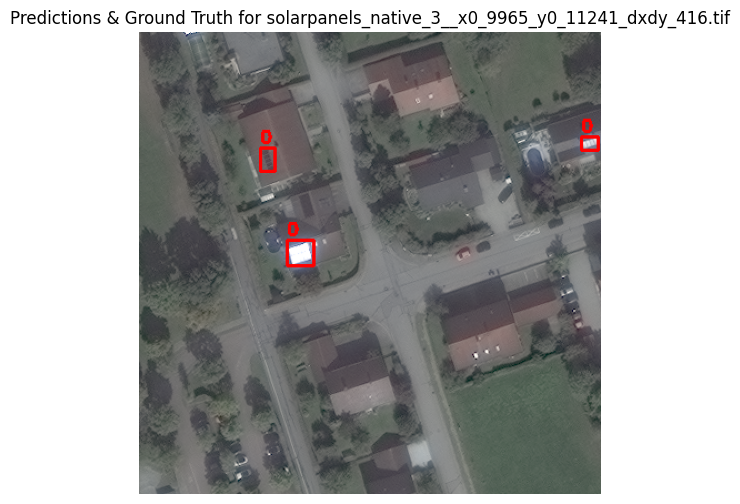


0: 416x416 9 solar_panels, 121.2ms
Speed: 2.3ms preprocess, 121.2ms inference, 22.1ms postprocess per image at shape (1, 3, 416, 416)


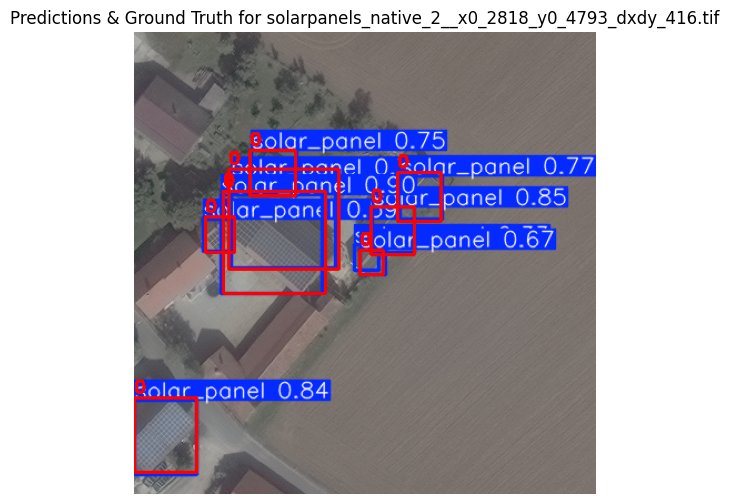


0: 416x416 1 solar_panel, 115.0ms
Speed: 2.8ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


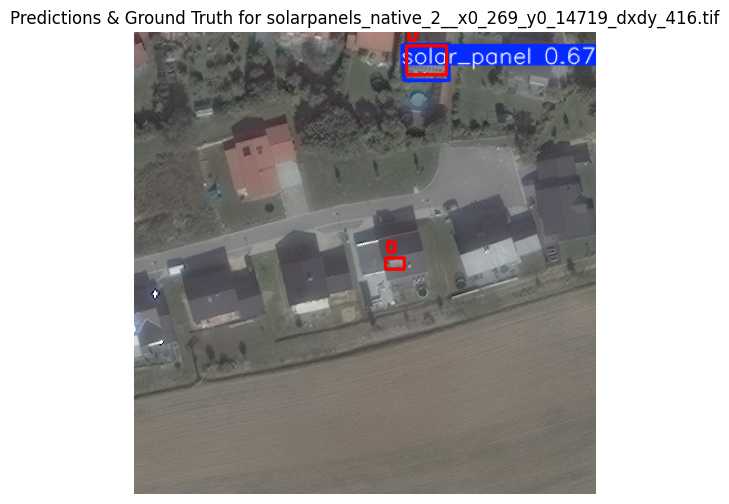


0: 416x416 3 solar_panels, 117.5ms
Speed: 2.9ms preprocess, 117.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)


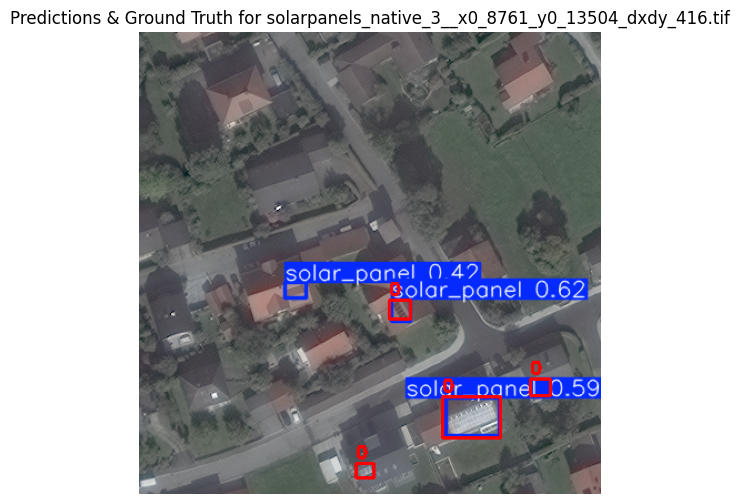


0: 416x416 3 solar_panels, 200.0ms
Speed: 2.3ms preprocess, 200.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


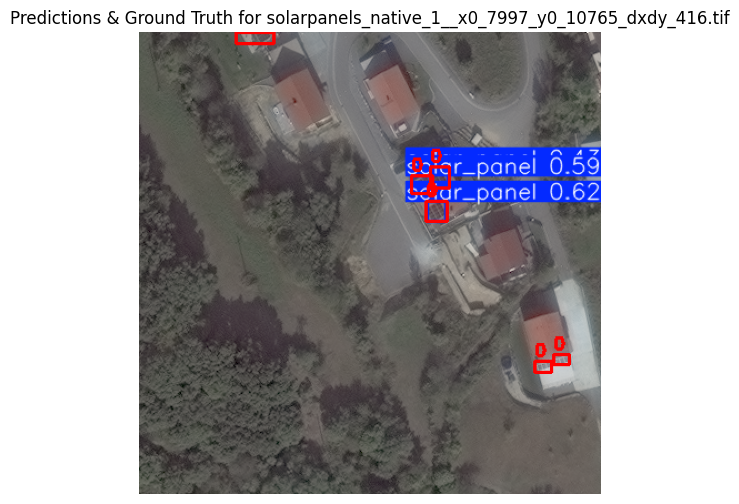

In [9]:
model = YOLO("/content/drive/MyDrive/solar_panel_detection/train3/weights/best.pt")
test_images_path = "/content/drive/MyDrive/srip_task/split_data/test/images/"
test_label_path = "/content/drive/MyDrive/srip_task/split_data/test/labels/"

if not os.path.exists(test_images_path):
    raise FileNotFoundError(f"Test image directory not found: {test_images_path}")

# Select 5 random test images
test_images = random.sample(os.listdir(test_images_path), 5)
test_images = [os.path.join(test_images_path, f) for f in test_images]

for img_path in test_images:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Unable to load {img_path}")
        continue

    results = model(img)
    for result in results:
        annotated_img = result.plot()

    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_file = os.path.join(test_label_path, base_name + ".txt")

    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()

                if len(parts) != 5:
                    continue

                label = parts[0]
                try:
                    x_center, y_center, w_norm, h_norm = map(float, parts[1:])
                except ValueError:
                    continue

                img_h, img_w = img.shape[:2]
                cx = int(x_center * img_w)
                cy = int(y_center * img_h)
                w = int(w_norm * img_w)
                h = int(h_norm * img_h)
                top_left = (int(cx - w / 2), int(cy - h / 2))
                bottom_right = (int(cx + w / 2), int(cy + h / 2))

                cv2.rectangle(annotated_img, top_left, bottom_right, (0, 0, 255), 2)
                cv2.putText(annotated_img, label, (top_left[0], top_left[1] - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predictions & Ground Truth for {os.path.basename(img_path)}")
    plt.savefig(f"foo{os.path.basename(img_path)}.png")
    plt.show()

    #red bounding box for ground truth
    #blue bounding box for predictions

In [ ]:
import onnx

onnx_model = onnx.load("solar_panel_detection/train2/weights/best.onnx")
for input_tensor in onnx_model.graph.input:
    print(input_tensor.name, input_tensor.type.tensor_type.shape)

images dim {
  dim_value: 1
}
dim {
  dim_value: 3
}
dim {
  dim_value: 416
}
dim {
  dim_value: 416
}



In [11]:
test_images = glob.glob(os.path.join(test_images_path, "*.tif"))

ground_truths = []
predictions = []

for img_path in test_images:
    img_name = os.path.basename(img_path).replace(".tif", ".txt")
    label_path = os.path.join(test_label_path, img_name)

    if os.path.exists(label_path):
        gt_data = np.loadtxt(label_path).reshape(-1, 5)
        gt_boxes = gt_data[:, 1:]
        gt_class_ids = gt_data[:, 0].astype(int)
    else:
        gt_boxes = np.empty((0, 4))
        gt_class_ids = np.array([], dtype=int)

    ground_truths.append({
        'boxes': gt_boxes,
        'class_ids': gt_class_ids
    })

    results = model(img_path)
    if results[0].boxes is not None:
        pred_boxes = results[0].boxes.xywh.cpu().numpy()
        pred_conf = results[0].boxes.conf.cpu().numpy().astype(float)
        pred_class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    else:
        pred_boxes = np.empty((0, 4))
        pred_conf = np.array([], dtype=float)
        pred_class_ids = np.array([], dtype=int)

    predictions.append({
        'boxes': pred_boxes,
        'confidences': pred_conf,
        'class_ids': pred_class_ids
    })


image 1/1 /content/drive/MyDrive/srip_task/split_data/test/images/solarpanels_native_3__x0_7909_y0_9356_dxdy_416.tif: 416x416 6 solar_panels, 308.1ms
Speed: 19.9ms preprocess, 308.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/srip_task/split_data/test/images/solarpanels_native_3__x0_10978_y0_9173_dxdy_416.tif: 416x416 8 solar_panels, 499.5ms
Speed: 3.1ms preprocess, 499.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/srip_task/split_data/test/images/solarpanels_native_3__x0_4769_y0_13391_dxdy_416.tif: 416x416 5 solar_panels, 331.3ms
Speed: 3.1ms preprocess, 331.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/drive/MyDrive/srip_task/split_data/test/images/solarpanels_native_3__x0_7363_y0_9576_dxdy_416.tif: 416x416 5 solar_panels, 465.9ms
Speed: 4.6ms preprocess, 465.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)



In [18]:
for gt in ground_truths:
  print(np.array(gt['boxes']))
  break

print()

for pred in predictions:
  print(pred)
  break

[[    0.83894     0.34736    0.057692    0.026442]
 [    0.55048     0.55529    0.052885    0.076923]
 [    0.38582     0.64183    0.069712      0.0625]
 [    0.16827     0.45433    0.076923    0.091346]
 [   0.022837      0.4988    0.045673      0.1274]
 [    0.57452     0.16226    0.048077    0.026442]]

{'boxes': array([[     225.29,      230.23,       25.81,       35.39],
       [     158.57,      268.29,      28.406,        25.9],
       [     70.356,      190.79,      34.022,      36.498],
       [     9.6481,      213.39,      18.911,      45.749],
       [     237.64,       68.31,      24.044,      13.201],
       [     349.49,      145.58,      20.447,      13.366]], dtype=float32), 'confidences': array([    0.74241,     0.66587,     0.65795,     0.53384,     0.51567,     0.45152]), 'class_ids': array([0, 0, 0, 0, 0, 0])}


In [25]:
def calculate_map(ground_truths, predictions, img_size=416):
    def convert_to_xyxy(boxes, is_normalized=False):
        if len(boxes) == 0:
            return np.empty((0, 4))

        if is_normalized:
            boxes = boxes * img_size

        x_center, y_center, width, height = boxes.T
        return np.column_stack((
            x_center - width/2,
            y_center - height/2,
            x_center + width/2,
            y_center + height/2
        ))

    gt_detections = [
        sv.Detections(
            xyxy=convert_to_xyxy(gt['boxes'], is_normalized=True),
            class_id=gt['class_ids'].astype(int)
        )
        for gt in ground_truths
    ]

    pred_detections = [
        sv.Detections(
            xyxy=convert_to_xyxy(pred['boxes']),
            confidence=pred['confidences'].astype(float),
            class_id=pred['class_ids'].astype(int)
        )
        for pred in predictions
    ]

    map_calculator = MeanAveragePrecision()
    map_result = map_calculator.update(pred_detections, gt_detections).compute()

    return map_result

final_map = calculate_map(ground_truths, predictions, img_size=416)
print(f"mAP50: {final_map.map50:.4f}")
print(f"mAP50-95: {final_map.map50_95:.4f}")


mAP50: 0.2583
mAP50-95: 0.1802


In [30]:
def convert_yolo_to_xyxy(normalized_boxes, img_size=416):
    if len(normalized_boxes) == 0:
        return np.empty((0, 4))

    abs_boxes = normalized_boxes * img_size
    x_center, y_center, width, height = abs_boxes.T
    return np.column_stack((
        x_center - width/2,
        y_center - height/2,
        x_center + width/2,
        y_center + height/2
    ))

def convert_xywh_to_xyxy(abs_boxes):
    if len(abs_boxes) == 0:
        return np.empty((0, 4))

    x_center, y_center, width, height = abs_boxes.T
    return np.column_stack((
        x_center - width/2,
        y_center - height/2,
        x_center + width/2,
        y_center + height/2
    ))

results = {
    'voc11': [],
    'coco101': [],
    'pr_auc': []
}

IMG_SIZE = 416

for gt_data, pred_data in zip(ground_truths, predictions):
    gt_boxes = convert_yolo_to_xyxy(gt_data['boxes'], IMG_SIZE)

    pred_boxes = convert_xywh_to_xyxy(pred_data['boxes'])
    conf_scores = pred_data['confidences']

    for method in results.keys():
        ap = compute_ap50(
            gt_boxes=gt_boxes.tolist(),
            pred_boxes=pred_boxes.tolist(),
            conf_scores=conf_scores.tolist(),
            method=method
        )
        results[method].append(ap)

final_metrics = {
    method: np.mean(scores)
    for method, scores in results.items()
}

print("Average Precision Scores:")
print(f"VOC11: {final_metrics['voc11']:.4f}")
print(f"COCO101: {final_metrics['coco101']:.4f}")
print(f"PR AUC: {final_metrics['pr_auc']:.4f}")

Average Precision Scores:
VOC11: 0.9487
COCO101: 0.9490
PR AUC: 0.9458


The difference in scores is because of how they are calculated. My custom AP50 checks each image one by one and picks the best matches first, which gives me 0.95. But supervision's mAP50 (0.26) looks at everything together and only allows one correct match per object, making it much lower. The really low mAP50-95 (0.18) means my model struggles to detect objects accurately when the overlap has to be really high. So, my scores show that my model is good at finding objects with at least 50% overlap, but supervision's method shows that I have problems with too many extra detections and being precise at higher thresholds.